# SML Practical

In [1]:
### Set basic parameters ###

global_seed = 2023 # set to ensure reproducibility
n_seeds = 1 # number of seeds used for estimating the accuracy
split_rate = 0.2 # proportion of data used as test set

## Data Loading and pre-processing

In [ ]:
# (running this cell once is enough)

### download required libraries ###
import importlib
import subprocess

# List of required libraries
required_libraries = ['numpy', 'matplotlib', 'seaborn', 'mrmr-selection', 'scikit-learn', 'xgboost']

# Check if each required library is installed, and install it if not
for library in required_libraries:
    try:
        # Try to import the library
        importlib.import_module(library)
    except ImportError:
        # If the library is not installed, install it using pip
        print(f"{library} is not installed. Installing...")
        subprocess.check_call(['pip', 'install', library])
        print(f"{library} has been successfully installed")


In [2]:
# (running this cell once is enough)
### import required libraries ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pre-processing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from mrmr import mrmr_classif
# classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBRFClassifier
# evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [3]:
np.random.seed(global_seed)

### load data 
X = pd.read_csv('data/X_train.csv', index_col = 0, header=[0, 1, 2]) # inputs 
y = pd.read_csv('data/y_train.csv', index_col = 0).squeeze('columns') # labels
# total number of rows and columns(attributes)
n, p = np.shape(X)

### transform class labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### check class labels
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label mapping:", label_mapping)

# use different seeds to test the algorithm
seeds = np.random.randint(0, 2025, size=n_seeds)
X_train_list = [None for _ in range(n_seeds)]
X_test_list = [None for _ in range(n_seeds)]
y_train_list = [None for _ in range(n_seeds)]
y_test_list = [None for _ in range(n_seeds)]
for i, seed in enumerate(seeds):
    ### split into train and test set  
    X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i] = train_test_split(X, y, test_size=split_rate, random_state=seed) 

### Set pre-process parameters here

In [159]:
preprocess_method = 'standard' # 'standard', 'minmax', 'none'
### Dimension reduction/feature selection
reduction_method = 'mrmr' # 'igr', 'mrmr', 'chroma', 'pca', 'lda', 'none'
# number of components to keep
n_components = 250 # will be ignored if reduction_method == 'none' or 'lda'
 # the chromagram selected
chroma_choice = 'chroma_stft' # only necessary for reduction_method == 'chroma'

## Pre-processing

### Scaling

In [160]:
### pre-processing
X_train_list_scaled = [None for _ in range(n_seeds)]
X_test_list_scaled = [None for _ in range(n_seeds)]
if preprocess_method == 'standard':
    for i in range(n_seeds):
        scaler = StandardScaler()
        X_train_list_scaled[i] = scaler.fit_transform(X_train_list[i])
        X_test_list_scaled[i] = scaler.transform(X_test_list[i])
elif preprocess_method == 'minmax':
    for i in range(n_seeds):
        scaler = MinMaxScaler()
        X_train_list_scaled[i] = scaler.fit_transform(X_train_list[i])
        X_test_list_scaled[i] = scaler.transform(X_test_list[i])
elif preprocess_method == 'none':
    X_train_list_scaled = X_train_list
    X_test_list_scaled = X_test_list
else:
    raise Exception('preprocess_method must be of the standard, minmax, none')

### Dimension Reduction/Feature selection

**igr(information gain ranking)**: selects the features with largest mutual information scores with the class labels  
**mrmr(Max-Relevance, and Min-Redundancy)**: forward selection technique, uses mutual information(relevance), but will subtract the redundancy (defined as average mutual information between feature with already selected features)  
**chroma**: simply select the one of three chromagrams and discard the other two

In [161]:
import time

def reduce(X_train, X_test, y_train, columns):
    """
    Reduce the X_train and X_test using specified method
    """

    start_time = time.time()
    if reduction_method == 'igr': ## information gain ranking algorithm 
        kbest = SelectKBest(score_func=mutual_info_classif, k=n_components)
        kbest.fit(X_train, y_train)
        selected_columns = X.columns[kbest.get_support()]

        # selected_indices = kbest.get_support()
        # feature_scores = kbest.scores_
        # features_with_scores = zip(selected_columns, feature_scores[selected_indices], selected_indices)
        # sorted_features_with_scores = sorted(features_with_scores, key=lambda x: x[1], reverse=True)
        # print("Selected Features:")
        # print("Selected Features (sorted by scores in descending order):")
        # for feature, score, index in sorted_features_with_scores:
        #     print(f"{feature}: {score} (index: {index})")

        X_train_reduced = kbest.transform(X_train)
        X_test_reduced = kbest.transform(X_test)
    elif reduction_method == 'mrmr': ## Max-Relevance, and Min-Redundancy
        X_train = pd.DataFrame(X_train, columns=columns)
        X_test = pd.DataFrame(X_test, columns=columns)
        selected_columns = mrmr_classif(X_train, 
                                    y_train, 
                                    K=n_components)
        X_train = pd.DataFrame(data=X_train, columns=X.columns)
        X_test = pd.DataFrame(data=X_test,  columns=X.columns)
        X_train_reduced = X_train[selected_columns]
        X_test_reduced = X_test[selected_columns]
    elif reduction_method == 'chroma':
        chromas = {'chroma_cens', 'chroma_cqt', 'chroma_stft'}
        removed_chromas = chromas.copy()
        removed_chromas.remove(chroma_choice)
        X_train_reduced = X_train[:, X.columns.get_level_values('feature').isin(removed_chromas) ]
        X_test_reduced = X_test[:, X.columns.get_level_values('feature').isin(removed_chromas) ]
    elif reduction_method == 'pca':
        # perform the full PCA decomposition
        pca = PCA(n_components=n_components)
        # find the principal compoennts
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)

        ### check PCA explained variance ratio
        # explained_variances = pca.explained_variance_ratio_
        # plt.plot(range(1, n_components+1), explained_variances[:n_components])
        # plt.title('explained variances by principal components')
        # plt.xlabel('PC index')
        # plt.ylabel('ratio of explained variance')
    elif reduction_method == 'lda':
        LDAclassifier = LinearDiscriminantAnalysis(n_components=7) # 8 classes in total 
        LDAclassifier.fit(X_train, y_train)

        X_train_reduced = LDAclassifier.transform(X_train)
        X_test_reduced = LDAclassifier.transform(X_test)
    else:
        raise Exception('reduction_method not implemented, please check the first cell for list of possible reduction methods')
    end_time = time.time()

    ###  count the number of features selected from each group of features (used for the feature selection methods)
    features = np.unique(X.columns.get_level_values('feature'))
    category_counts = {}
    for feature in features:
        selected_columns = pd.MultiIndex.from_tuples(selected_columns, names=['feature', 'statistics', 'number'])
        category_counts[feature] = np.sum(selected_columns.get_level_values('feature') == feature) / np.sum(X.columns.get_level_values('feature') == feature)
    print(category_counts)

    return X_train_reduced, X_test_reduced, (end_time - start_time)
    
reduction_times = [None for _ in range(n_seeds)]

if reduction_method != 'none':
    X_train_list_reduced = [None for _ in range(n_seeds)]
    X_test_list_reduced = [None for _ in range(n_seeds)]

    for i in range(n_seeds):
        X_train_list_reduced[i], X_test_list_reduced[i], reduction_times[i] = reduce(X_train_list_scaled[i], X_test_list_scaled[i], 
                                                                 y_train_list[i], columns=X.columns)
else:
    X_train_list_reduced = X_train_list_scaled
    X_test_list_reduced = X_test_list_scaled
    reduction_times = [0 for _ in range(n_seeds)]

100%|██████████| 250/250 [00:57<00:00,  4.33it/s]

{'chroma_cens': 0.14285714285714285, 'chroma_cqt': 0.20238095238095238, 'chroma_stft': 0.4642857142857143, 'mfcc': 0.7357142857142858, 'rmse': 0.7142857142857143, 'spectral_bandwidth': 0.5714285714285714, 'spectral_centroid': 0.8571428571428571, 'spectral_contrast': 0.7755102040816326, 'spectral_rolloff': 0.5714285714285714, 'tonnetz': 0.40476190476190477, 'zcr': 0.7142857142857143}


## Algorithm Training

### Set training parameters here, and click "execute cell and below"

In [233]:
### training parameters
classifier = 'XGBRF' # 'SVM', 'KNN', 'LR', 'RF', 'XGBRF' 
# parameters for kernelSVM (support vector machine)
params_SVM = {
    'kernel': 'rbf', # the kernel used
    'C': 3.0, # regularisation strength is 1/C 
    'gamma': 'scale' # the scale of rbf and poly kernels
} 
# parameters for k-nearest neighbours
params_KNN = {
    'n_neighbors': 10, # the number of neighbours selected
    'algorithm' : 'auto' # Algorithm used to compute the nearest neighbors: 'auto', 'ball_tree'. 'kd_tree', 'brute'
} 
# parameters for logistic regression
params_LR = {
    'solver' : 'lbfgs', # optimiser used: 'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'
    'C': 1, # regularisation strength is 1/C
    'penalty' : 'l2' # 'l1', 'l2', 'elasticnet'
}
# parameters for random forest
params_RF = {
    'n_estimators' : 200, # number of trees in the forest
    'max_depth': 5, # maximum tree depth
    'min_samples_split': 5, # minimum size of node allowed for splitting
    'min_samples_leaf': 3,  # minimum leaf node size 
    'max_features': 'auto' # number of features used in each tree, one of 'auto', 'sqrt', 'log2' or None(use all features)
}
# parameters for gradient boosting random forest
params_XGBRF = {
    'learning_rate': 0.01, # step size shrinkage used in each boosting iteration
    'n_estimators': 200, # number of trees
    'max_depth': 10, # max tree depth
    'subsample': 0.5, # fraction of samples used for fitting each tree
    'colsample_bynode': 0.5, # fraction of features used for fitting each tree
    'importance_type' : 'cover' # does not affect training
}

params_dict = {
    'SVM' : params_SVM,
    'KNN' : params_KNN,
    'RF' : params_RF,
    'XGBRF' : params_XGBRF
}

In [ ]:
## fit the model and record the training time

train_times = [None for _ in range(n_seeds)]
models = [None for _ in range(n_seeds)]

if classifier == 'SVM':
    for i in range(n_seeds):
        models[i] = SVC(random_state=seed, **params_SVM) 
        start = time.time()
        models[i].fit(X_train_list_reduced[i], y_train_list[i])
        end = time.time()
        train_times[i] = end - start
elif classifier == 'KNN':
    for i in range(n_seeds):
        models[i] = KNeighborsClassifier(**params_KNN)
        start = time.time()
        models[i].fit(X_train_list_reduced[i], y_train_list[i])
        end = time.time()
        train_times[i] = end - start
elif classifier == 'LR':
    for i in range(n_seeds):
        models[i] = LogisticRegression(random_state=global_seed, **params_LR)
        start = time.time()
        models[i].fit(X_train_list_reduced[i], y_train_list[i])
        end = time.time()
        train_times[i] = end - start
elif classifier == 'RF':
    for i in range(n_seeds):
        models[i] = RandomForestClassifier(random_state=global_seed, **params_RF)
        start = time.time()
        models[i].fit(X_train_list_reduced[i], y_train_list[i])
        end = time.time()
        train_times[i] = end - start
elif classifier == 'XGBRF':
    for i in range(n_seeds):
        models[i] = XGBRFClassifier(random_state=global_seed, **params_XGBRF)
        start = time.time()
        models[i].fit(X_train_list_reduced[i], y_train_list[i])
        end = time.time()
        train_times[i] = end - start

## Algorithm Evaluation

In [226]:
predict_times = [None for _ in range(n_seeds)]
test_accs = [None for _ in range(n_seeds)]
gen_gaps = [None for _ in range(n_seeds)]
test_f1s = [None for _ in range(n_seeds)]
conf_mats = [None for _ in range(n_seeds)]

for i in range(n_seeds):
    start = time.time()
    y_pred = models[i].predict(X_test_list_reduced[i])
    end = time.time()
    predict_times[i] = end - start

    y_pred_train = models[i].predict(X_train_list_reduced[i])

    train_acc = accuracy_score(y_train_list[i], y_pred_train)
    test_acc = accuracy_score(y_test_list[i], y_pred)
    test_accs[i] = test_acc
    gen_gaps[i] = train_acc - test_acc
    test_f1s[i] = f1_score(y_test_list[i], y_pred, average='micro')
    conf_mats[i] = confusion_matrix(y_test_list[i], y_pred)

print(f'-------- Current classifier : {classifier} ---------')
if reduction_method == 'none':
    n_components = X.shape[1]
print(f'-------- Reduction method : {reduction_method}, dim = {n_components} ---------')
print(f'parameters: {params_dict[classifier]}')
print(f'test set accuracy {np.mean(test_accs)} +- {1.96*np.std(test_accs)}')
test_errors = 1 - np.array(test_accs)
print(f'average generalisation error {np.mean(test_errors)} +- {1.96*np.std(test_errors)}')
print(f'average generalisation gap {np.mean(gen_gaps)}')
# print(f'average test set f1 score {np. mean(test_f1s)}')
print(f'average feature reduction/selection time {np.mean(reduction_times)}')
print(f'average training time {np.mean(train_times)}')
print(f'average prediction time {np.mean(predict_times)}')

conf_mats = np.array(conf_mats)
avg_conf_mat = np.mean(conf_mats, axis=0) # average confusion matrix

-------- Current classifier : XGBRF ---------
-------- Reduction method : mrmr, dim = 250 ---------
parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 10, 'subsample': 0.5, 'colsample_bynode': 0.5, 'importance_type': 'cover'}
test set accuracy 0.5741666666666667 +- 0.0
average generalisation error 0.4258333333333333 +- 0.0
average generalisation gap 0.3631249999999999
average feature reduction/selection time 68.15013694763184
average training time 24.826406002044678
average prediction time 0.02850508689880371


In [230]:
conf_mat = np.load('mlp_confusion_matrix_test.npz')

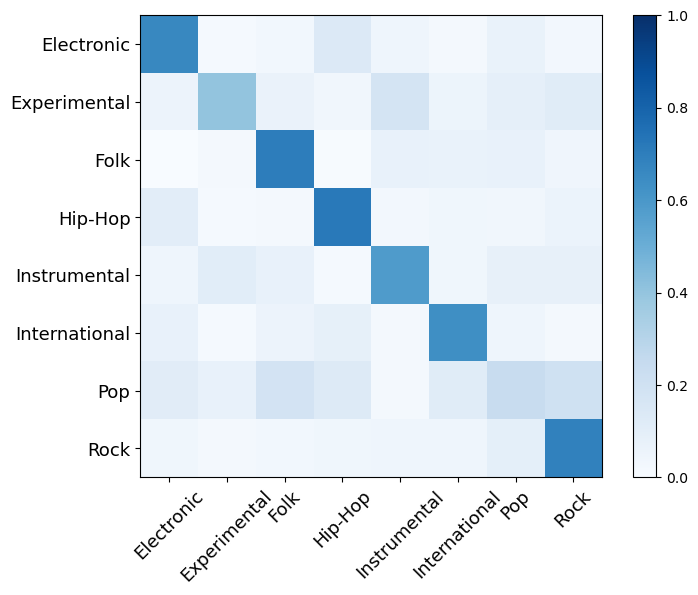

In [235]:
def plot_heatmap(matrix, title=''):
    """ Plot the confusion matrix """
    axis_labels = label_encoder.classes_
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    # plt.title(f'Plot of confusion matrix {title}')
    plt.xticks(np.arange(len(axis_labels)), axis_labels, rotation=45, fontsize=13)
    plt.yticks(np.arange(len(axis_labels)), axis_labels, fontsize=13)
    plt.savefig('figures/confusion_matrix_rf', dpi=300, bbox_inches="tight")

plot_heatmap(avg_conf_mat / np.unique(y_test_list[0], return_counts=True)[1], f'classifier: {classifier}')

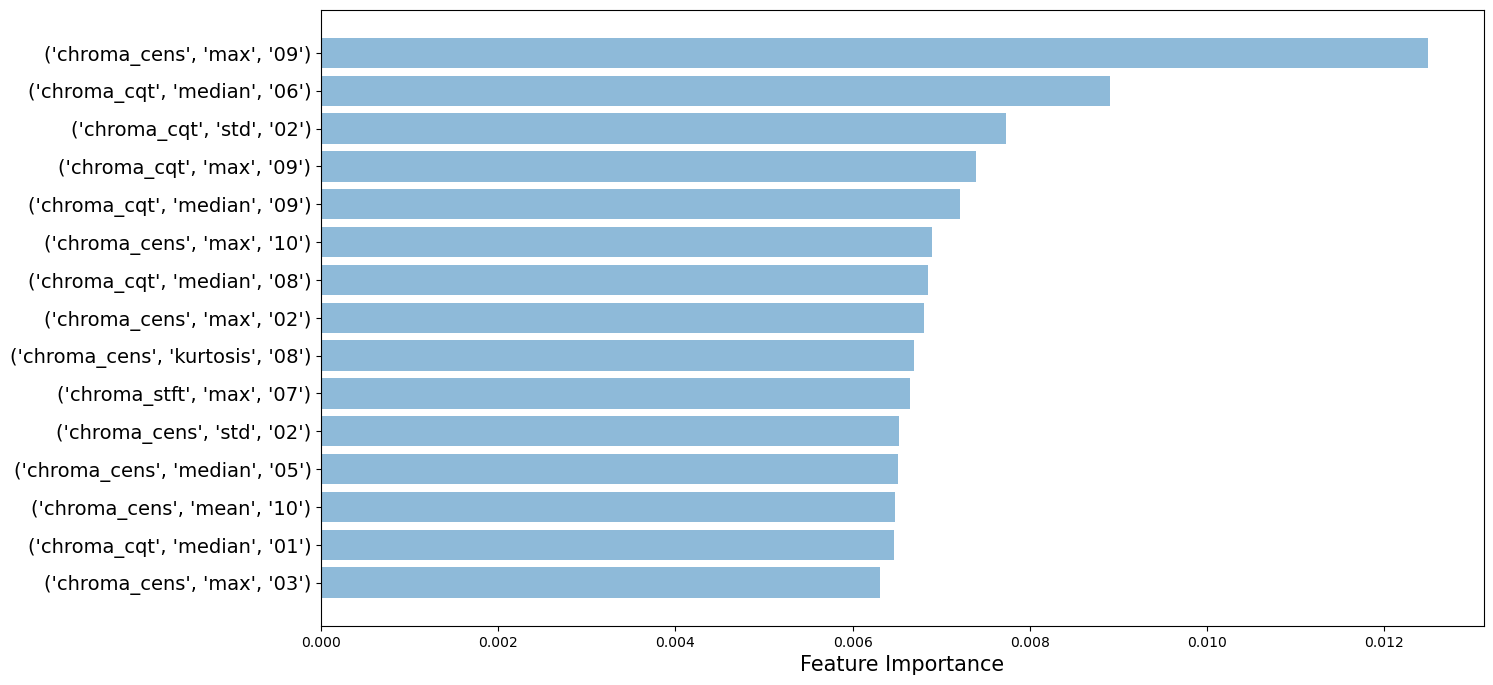

In [228]:
# Get feature importances
importance_scores = models[0].feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

labels = [X.columns[i] for i in sorted_indices]

# labels_array = []
# for x in labels:
#     labels_array.append(" ".join([x[0], x[2], x[1]]))


# Plot the top 20 most important features
n_features = 15
plt.figure(figsize=(15, 8))
plt.barh(range(n_features), importance_scores[sorted_indices][:n_features], align='center', alpha=0.5)
plt.yticks(range(n_features), labels[:n_features], rotation=0, fontsize=14)
plt.xlabel('Feature Importance', fontsize=15)
# plt.ylabel('Feature', fontsize=15)
# plt.title(f'Top {n_features} Most Important Features')
plt.gca().invert_yaxis() 

plt.savefig('figures/xgboost_feature_weight.png', bbox_inches="tight", dpi=300)